In [1]:
# Cell 1: Mount Drive and Load Data
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load dataset from Google Drive
dataset = pd.read_csv('/content/drive/MyDrive/stock_prediction_data/processed_dataset.csv')

print(f"Loaded dataset: {dataset.shape}")
print(f"Samples: {len(dataset)}")
print(f"Features: {list(dataset.columns)}")
print(f"\nFirst few rows:")
dataset.head()

Mounted at /content/drive
Loaded dataset: (60, 11)
Samples: 60
Features: ['ticker', 'date', 'revenue', 'revenue_growth', 'profit_margin', 'gross_margin', 'net_income', 'total_assets', 'debt_to_assets', 'quarter_price', 'target_return']

First few rows:


,ticker,date,revenue,revenue_growth,profit_margin,gross_margin,net_income,total_assets,debt_to_assets,quarter_price,target_return
0,AAPL,2016-06-30,9.223521e+10,-0.023604,0.246543,0.446543,2.273998e+10,2.946275e+11,0.368536,96.10,0.181582
1,AAPL,2016-09-30,9.005814e+10,0.000446,0.244147,0.444147,2.198739e+10,3.128407e+11,0.334535,112.71,0.031763
2,AAPL,2016-12-31,9.009828e+10,0.049382,0.263564,0.463564,2.374666e+10,2.577689e+11,0.279042,117.26,0.199386
3,AAPL,2017-03-31,9.454754e+10,-0.050265,0.202168,0.402168,1.911449e+10,2.347166e+11,0.274697,140.64,0.035481
4,AAPL,2017-06-30,8.979514e+10,0.144666,0.257856,0.457856,2.315423e+10,2.449246e+11,0.236446,146.28,0.048605


In [2]:
# Cell 2: Prepare Features and Target
feature_columns = [
    'revenue', 'revenue_growth', 'profit_margin',
    'gross_margin', 'net_income', 'total_assets',
    'debt_to_assets', 'quarter_price'
]

X = dataset[feature_columns].copy()
y = dataset['target_return'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(f"  Mean return: {y.mean():.4f}")
print(f"  Std return: {y.std():.4f}")
print(f"  Min: {y.min():.4f}, Max: {y.max():.4f}")

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_columns)

print(f"\nScaled features sample:")
X_scaled.head()


Features shape: (60, 8)
Target shape: (60,)

Target statistics:
  Mean return: 0.1038
  Std return: 0.1255
  Min: -0.0840, Max: 0.6491

Scaled features sample:


,revenue,revenue_growth,profit_margin,gross_margin,net_income,total_assets,debt_to_assets,quarter_price
0,1.010857,-0.844467,-0.104185,-0.104185,1.715628,1.187630,1.455955,-0.506617
1,0.955868,-0.428599,-0.123009,-0.123009,1.612539,1.343723,1.140139,-0.452077
2,0.956882,0.417629,0.029493,0.029493,1.853521,0.871738,0.624713,-0.437137
3,1.069262,-1.305500,-0.452704,-0.452704,1.219016,0.674172,0.584355,-0.360367
4,0.949225,2.065313,-0.015335,-0.015335,1.772371,0.761658,0.229073,-0.341848


In [6]:
# Cell 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 48 samples
Test set: 12 samples


In [7]:
# Cell 4: Train XGBoost Model
!pip install xgboost -q

import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

print("Model trained successfully!")


Model trained successfully!


In [8]:
# Cell 5: Evaluate Model Performance
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("=== Training Set ===")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"  MAE:  {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"  R2:   {r2_score(y_train, y_pred_train):.4f}")

print(f"\n=== Test Set ===")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"  MAE:  {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"  R2:   {r2_score(y_test, y_pred_test):.4f}")

# Direction accuracy (did we predict up/down correctly?)
direction_correct = np.sum(np.sign(y_test) == np.sign(y_pred_test))
direction_accuracy = direction_correct / len(y_test)
print(f"\n=== Direction Accuracy ===")
print(f"  {direction_correct}/{len(y_test)} = {direction_accuracy:.1%}")


=== Training Set ===
  RMSE: 0.0193
  MAE:  0.0160
  R2:   0.9778

=== Test Set ===
  RMSE: 0.0898
  MAE:  0.0778
  R2:   0.1821

=== Direction Accuracy ===
  10/12 = 83.3%


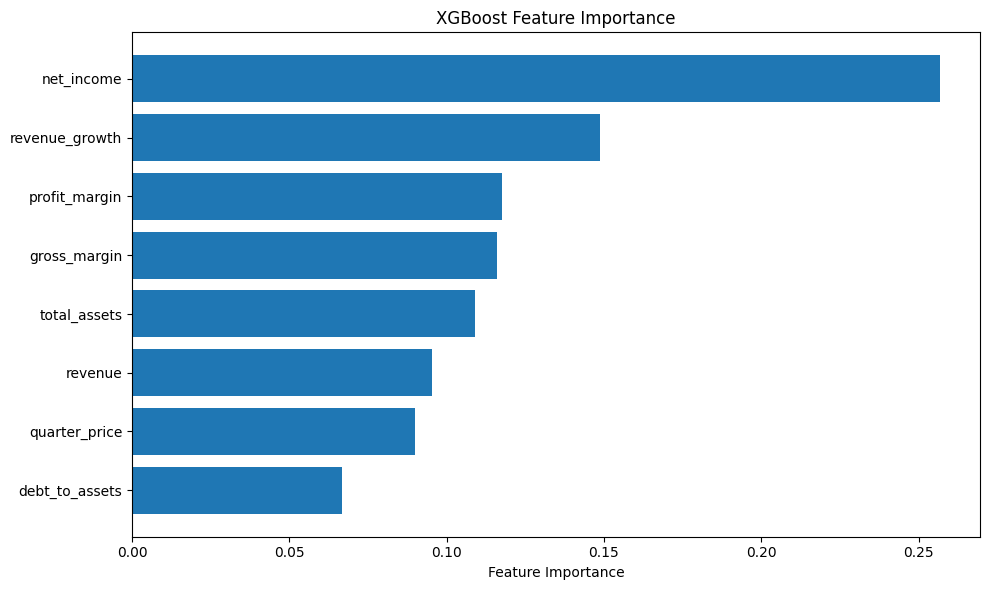

Saved feature_importance.png to Google Drive


In [9]:
# Cell 6: Feature Importance
import matplotlib.pyplot as plt

importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance['feature'], importance['importance'])
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/stock_prediction_data/feature_importance.png', dpi=150)
plt.show()

print("Saved feature_importance.png to Google Drive")


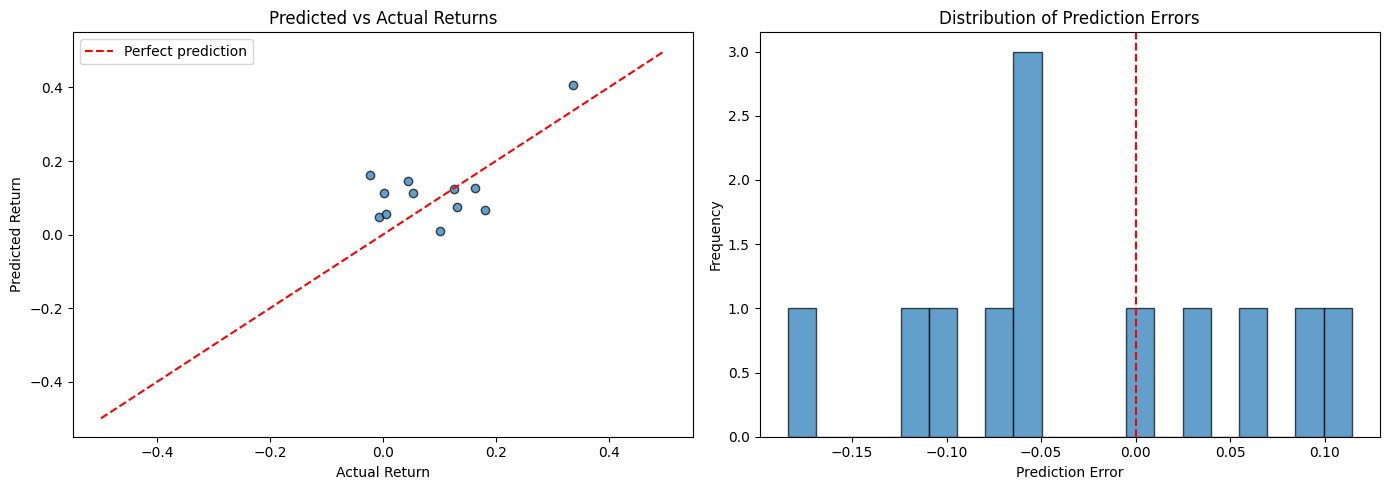

Saved model_results.png to Google Drive


In [10]:
# Cell 7: Predictions vs Actual Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_test, alpha=0.7, edgecolor='black')
axes[0].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Return')
axes[0].set_ylabel('Predicted Return')
axes[0].set_title('Predicted vs Actual Returns')
axes[0].legend()

# Residuals
residuals = y_test - y_pred_test
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Errors')
axes[1].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/stock_prediction_data/model_results.png', dpi=150)
plt.show()

print("Saved model_results.png to Google Drive")


In [11]:
# Cell 8: Save Model and Results
results = {
    'model': model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'metrics': {
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'direction_accuracy': float(direction_accuracy)
    }
}

with open('/content/drive/MyDrive/stock_prediction_data/model_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Saved to Google Drive:")
print("  - model_results.pkl")
print(f"\nFinal Results:")
for k, v in results['metrics'].items():
    print(f"  {k}: {v:.4f}")


Saved to Google Drive:
  - model_results.pkl

Final Results:
  train_rmse: 0.0193
  test_rmse: 0.0898
  train_r2: 0.9778
  test_r2: 0.1821
  direction_accuracy: 0.8333
